In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Problem Description

- This dataset consists of reviews of fine foods from amazon. Period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include : 
1. product 
2. User information
3. Ratings
4. plain text review
- It also includes reviews from all other Amazon categories.
- Amazon Food Review Data [Link](https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv)

### Import Packages

In [6]:
# Add environment Packages paths to conda
import os, sys
env_name = "food_review"
sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('wordnet')
# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\badie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read Dataset

In [7]:
%%time
df = pd.read_csv('Reviews.csv')
df = df[:10000]
df.head(2)

Wall time: 2.35 s


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [8]:
df.shape

(10000, 10)

In [9]:
f"{df.shape[0]:,} Review"

'10,000 Review'

In [10]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [11]:
df_text.duplicated().sum()

487

In [12]:
df_text.drop_duplicates(inplace=True)
df_text.reset_index(drop=True ,inplace =True)
df_text.head(2)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [13]:
df_text['target'] = df_text['Score'].apply(lambda x : 1 if x >= 3 else 0)
df_text.head()

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


#### Plot Countplot for target Variable

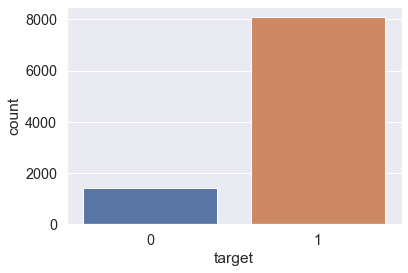

In [14]:
sns.countplot(x =df_text['target']);

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [15]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

2021-08-27 19:35:59.280 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-08-27 19:35:59.281 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


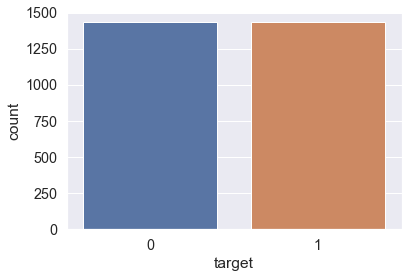

In [16]:
## PLot the target again after balancing
sns.countplot(x =df_text_balanced['target']);

### Text Pre-Processing

In [17]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()
stop_words = list(stop_words)
stop_words.remove('not')

In [18]:
def lemmatizeSentence(tokens):
    New_tokens =[]
    
    for sent in tokens :
        lem_sentence=[]
        for word in sent:
            #word = lemmatizer.lemmatize(word)
            lem_sentence.append(lemmatizer.lemmatize(word,pos="v"))
            
        New_tokens.append(lem_sentence)
        
    return New_tokens

In [19]:
## Clean your reviews using lemmatizer & stopwords

final_tokens = [word_tokenize(x) for x in df_text_balanced.Text]

# remove punctuations and stop words
punctuations=[ '?' , ':' , '!' , '.' , ',' , ';' , '>'  ,'<' , '/' ,'\\' ,'-' ,'_' , '`' ,',' ,'br' ,'``']

for sent in final_tokens :
    for word in list(sent) :
        if word in (punctuations or stop_words) :
           
            sent.remove(word)
#len(final_tokens)
# lemmatization
final_tokens = lemmatizeSentence(final_tokens)

df_text_balanced.reset_index(drop=True ,inplace =True)

df_text_balanced['New_Text'] = pd.Series(final_tokens).apply(lambda X: ' '.join(X))
df_text_balanced.head(5)


,Text,Score,target,New_Text
0,"My brother owns a Keurig one cup coffee maker,...",5,1,My brother own a Keurig one cup coffee maker w...
1,This is the second time I've ordered this prod...,5,1,This be the second time I 've order this produ...
2,I use vita coco coconut water with pineapple t...,5,1,I use vita coco coconut water with pineapple t...
3,we love this pancake / waffle mix. It's hard ...,5,1,we love this pancake waffle mix It 's hard to ...
4,I am a big fan of anything Annie's so it is no...,5,1,I be a big fan of anything Annie 's so it be n...


### Split Test & Training Data

In [20]:
X = df_text_balanced['New_Text']
y = df_text_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
- Use TfidfVectorizer
- fit on the training data only
- transform on training and test

In [21]:
## TFIDF embedding for the Description
#from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf =  vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer_tfidf.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [22]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((2006, 8049), (860, 8049))

### Modelling

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [24]:
## initialize your Model
clf = RandomForestClassifier(n_jobs=3) 
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 80.47%


### Raw Instance Prediction

In [35]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = review
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive review" if prediction == 1 else "Negative review"

In [36]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [37]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive review'

In [38]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative review'

### Saving Models for Deployment

In [39]:
import pickle

In [40]:
# Get the notebook path
import os.path
path = os.getcwd()
# Set the paths
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = path+'\\' +model_name
vect_path = path+'\\' +vectorizer_name

## Save model
pickle.dump(clf, open(model_path, 'wb'))

## Save tfidf-vectorizer
pickle.dump(vectorizer_tfidf, open(vect_path, 'wb'))

### Load model Again and test them

In [41]:
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_vect = pickle.load(open(vect_path, 'rb'))

In [42]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive review'

In [43]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative review'

# Great Job !
### Now Deploy your ML model using Streamlit Framework

In [47]:
import streamlit as st

In [ ]:
user_input = st.text_input("Enter your review")
result = raw_test(user_input, model, vectorizer)
st.success(result) 